In [5]:
import pm4py
from analysis import load_log
from pm4py.objects.log.obj import EventLog, Trace
from collections import Counter
from analysis import calculate_interarrival_times
import pandas as pd
from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import kstest
import matplotlib.pyplot as plt
from petri_functions_metrics import time_between_events_pn

In [6]:
log = load_log("/Users/ethanjohnson/Desktop/newtwitter/uae/uae-bad-full.xes")

parsing log, completed traces :: 100%|██████████| 12378/12378 [00:00<00:00, 19096.64it/s]


In [7]:
# creating an event log with 3 users with traces A->B->c and A->C->B

new_log = EventLog()

# create list of case:concept:name that contains users required
trace_id = []
user_name = ['u1043651878058364928', 'u1064258639450554368', 'u1062765065449934848']
for trace in log:
    count = 0
    for event in trace:
        if event['concept:name'] in user_name:
            count += 1
            if count == 3:
                trace_id.append(trace.attributes['concept:name'])

# create new log using only the events containing these users

for trace in log:
    new_trace = Trace()
    if trace.attributes['concept:name'] in trace_id:
        for event in trace:
            if event['concept:name'] in user_name:
                new_trace.append(event)
        new_log.append(new_trace)


print(len(new_log))


1303


/Users/ethanjohnson/.local/share/virtualenvs/mphil-project-KaAb4vnI/lib/python3.10/site-packages/pm4py/utils.py:537: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


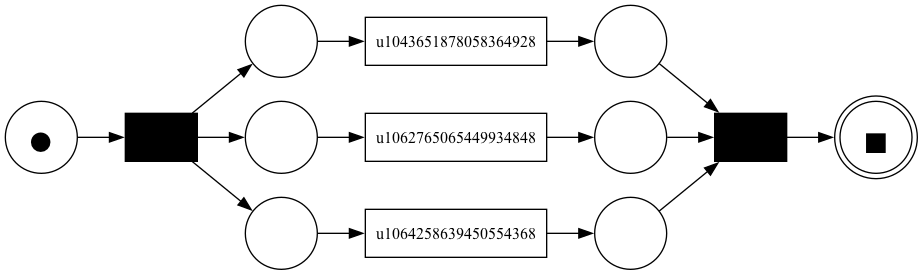

In [5]:
net, im, fm = pm4py.discover_petri_net_inductive(new_log)

pm4py.view_petri_net(net, im, fm)

In [8]:
# find the number of times each event occurs

first_event = []

for trace in new_log:
    for event in trace:
        first_event.append(event['concept:name'])
        break

Counter(first_event)
    

# dist of time where a precedes b





Counter({'u1043651878058364928': 933,
         'u1062765065449934848': 272,
         'u1064258639450554368': 98})

In [9]:
T_1 = [] # before event c
T_2 = [] # after event c

# event a - u1043651878058364928
# event b - u1064258639450554368
# event c - u1062765065449934848

# split event logs based on whether a, b, or c is the starting event

a_log = EventLog()
b_log = EventLog()
c_log = EventLog()

for trace in new_log:
    for event in trace:
        if event['concept:name'] == 'u1043651878058364928':
            a_log.append(trace)
            break
        if event['concept:name'] == 'u1064258639450554368':
            b_log.append(trace)
            break
        if event['concept:name'] == 'u1062765065449934848':
            c_log.append(trace)
            break

In [40]:

# find the interarrival times for T_1 and T_2

for trace in a_log:
    count = 0
    for event in trace:
        if count == 0:
            first_event = event
            count+=1
            continue
        if event['concept:name'] == 'u1064258639450554368':
            time = (event['time:timestamp'] - first_event['time:timestamp']).total_seconds()
            T_1.append(time)
        if event['concept:name'] == 'u1062765065449934848':
            first_event = event

for trace in c_log:
    count = 0
    for event in trace:
        if count == 0:
            first_event = event
            count+=1
            continue
        if event['concept:name'] == 'u1064258639450554368':
            time = (event['time:timestamp'] - first_event['time:timestamp']).total_seconds()
            T_2.append(time)
        if event['concept:name'] == 'u1062765065449934848':
            first_event = event


T_1 = [x/3600 for x in T_1]
T_2 = [x/3600 for x in T_2]

In [41]:
# find the interarrival times for the petri net representation

petri_time = time_between_events_pn(new_log)



discovering...


replaying log with TBR, completed variants :: 100%|██████████| 6/6 [00:00<00:00, 2640.97it/s]


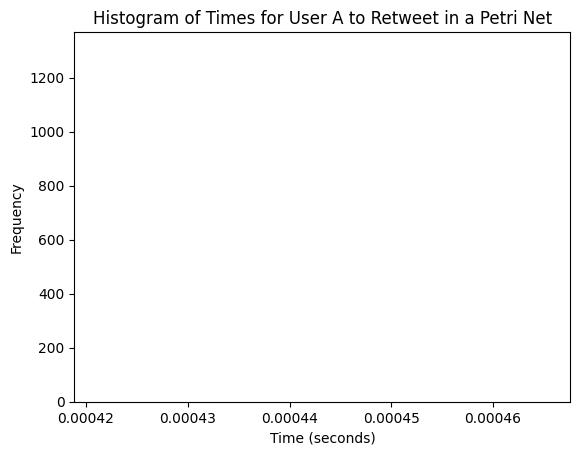

In [42]:
plt.hist(petri_time, bins = 1, label = 'petri_time', color = 'green')
plt.xlabel('Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Times to Retweet in a Petri Net')

plt.show()


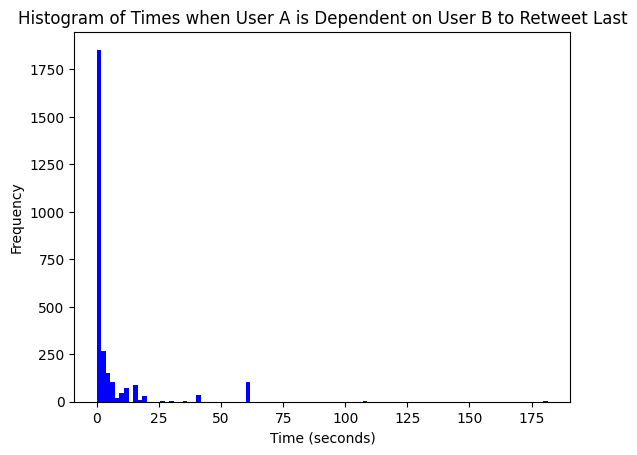

In [43]:

plt.hist(T_1, bins = 100, color = 'blue', label='T_1')
plt.xlabel('Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Times when User A is Dependent on User B to Retweet Last')

plt.show()


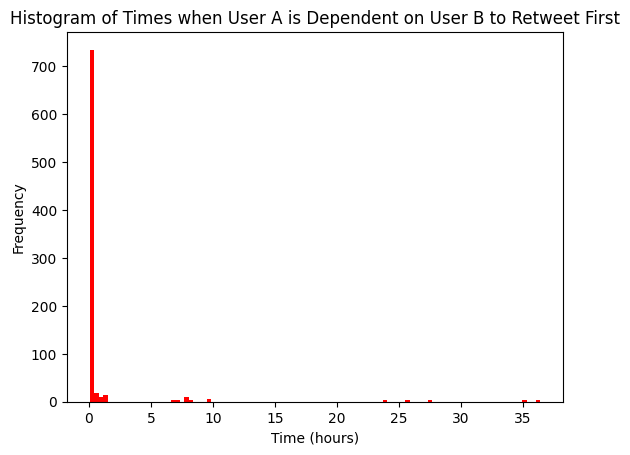

In [44]:

plt.hist(T_2, bins = 100, color = 'red', label = 'T_2')
plt.xlabel('Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Times when User A is Dependent on User B to Retweet First')

plt.show()

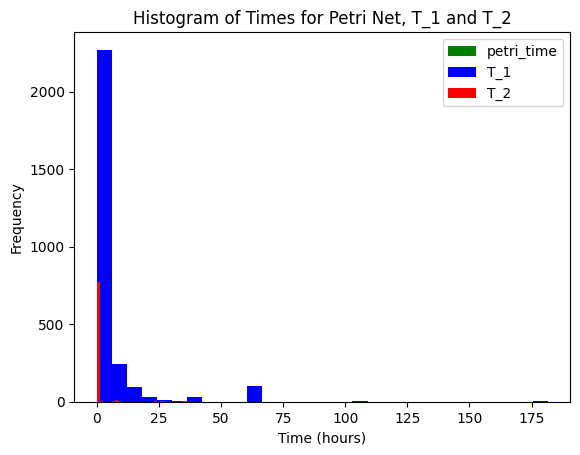

T_1, T_2
KstestResult(statistic=0.69, pvalue=4.9622936758674526e-23, statistic_location=2.007059656479412e-35, statistic_sign=-1)
P_1, petri
KstestResult(statistic=1.0, pvalue=2.2087606931995054e-59, statistic_location=0.0, statistic_sign=-1)
P_2, petri
KstestResult(statistic=0.86, pvalue=2.6058774037713476e-38, statistic_location=0.0, statistic_sign=1)


In [45]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(petri_time, bins = 30, label = 'petri_time', color = 'green')
plt.hist(T_1, bins = 30, color = 'blue', label='T_1')
plt.hist(T_2, bins = 30, color = 'red', label = 'T_2')
plt.xlabel('Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Times for Petri Net, T_1 and T_2')


mu_T2, std_T2 = norm.fit(T_2) 
mu_T1, std_T1 = norm.fit(T_1)
mu_petri, std_petri = norm.fit(petri_time)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p_T1 = norm.pdf(x, mu_T1, std_T1)
p_T2 = norm.pdf(x, mu_T2, std_T2)
p_petri = norm.pdf(x, mu_petri, std_petri)

plt.legend()
plt.show()

print('T_1, T_2')
print(kstest(p_T1, p_T2))
print('P_1, petri')
print(kstest(p_T1, p_petri))
print('P_2, petri')
print(kstest(p_petri, p_T2))
